# 8. Generative Deep Learning

<b style="color: maroon">Note: This notebook was run on Colab, using 1 GPU. You cannot run this notebook without a GPU.</b>

### Neural Style Transfer
Another major development in deep learning driven image modification is neural style transfer by Gatys et al. in 2015. Neural style transfer consists of applying the style of a reference image to a target image while conserving the content of the target image.

<img src="img83.png" width="1000">

In this context, <u>style</u> means textures, colours and visual patterns in the image at various spatial scales, and the <u>content</u> is the higher-level macrostructure of the image. In the above example, the blue-and-yellow circular brushstrokes from Van Gogh's Starry Night is considered to be the style while the buildings in the Tübingen photograph are considered to be the content.

The key concept behind style transfer is the same idea that is central to all deep-learning algorithms. <u>Define a loss function to specify what you want to achieve, and minimise this loss.</u> In this case, we want to conserve the content of the original image while adopting the style of the reference image. 

Let 
- $\text{img}_G$ be the generated image,
- $\text{img}_S$ be the style image and 
- $\text{img}_C$ be the content image.
- $C(\text{img})$ is a function to express the content representation of the image
- $S(\text{img})$ is a function to express the style representation of the image

So the loss function to minimise is:
$$\begin{align}
\text{loss} = \text{distance}(C(\text{img}_C) - C(\text{img}_G)) &+ \text{distance}(S(\text{img}_S) - S(\text{img}_G))
\end{align}$$

Here, $\text{distance}(\cdot)$ is a norm function like the L2 norm. So, style transfer is minimising the distance between the styles of $\text{img}_S$ and $\text{img}_G$, simultaneously minimising the distance between the content of $\text{img}_C$ and $\text{img}_G$. 

In this implementation, we can use deep CNNs to mathematically define the style and content functions.

#### Content Loss

or mathematically, $\text{distance}(C(\text{img}_C) - C(\text{img}_G))$. Recall that activations from lower layers contain local information (lines & dots) while activations from higher layers contain global, abstract information (ears, nose). Similarly, the different layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Hence, the content of an image, which is more global and abstract, is expected to be captured at the <u>higher layers of the convnet</u>.

Hence, a good candidate for content loss is the L2 norm difference between the activations of an upper layer in a pretrained convnet, computed over the target image, $\text{img}_C$ and the activations often same layer computer over the generated image, $\text{img}_G$. This ensures the layer sees similar images when it looks at $\text{img}_C$ and $\text{img}_G$.

#### Style Loss

or mathematically, $\text{distance}(S(\text{img}_S) - S(\text{img}_G))$. While the content loss uses only a single upper layer, the style loss, as defined by Gatys et al., uses multiple layers of a convnet: capture the appearance of $\text{img}_G$ at all spatial scales extracted by the convnet, not just a single scale.

For style loss, Gatys et al. uses the <b>Gram Matrix</b> of a layer's activations: the inner product of the feature maps of a given layer. This inner product can be understood as representing a map of the correlations between the layer's features. These feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically correspond to the appearance of the textures found at that scale.

Hence, the style loss aims to preserve similar internal correlations within the activations of different layers, across simg and gimg. In turn this guarantees that the textures found at different spatial scales look similar across simg and gimg.

In short, we can use a pretrained convnet to define a loss that does the following:
- Preserve content by maintaining similar high-level layer activations between cimg and gimg. The convnet should "see" that both images contain the same things
- Preserve style by maintaining similar correlations within activations for both low-level layers and high-level layers. Feature correlations capture textures: both $\text{img}_S$ and $\text{img}_G$ should share the same textures at different spatial scales.


In [1]:
import time
import functools
import os

import numpy as np
import PIL.Image
import IPython.display as display
import matplotlib.pyplot as plt

import tensorflow as tf

def prestep_find_gpu():
    import tensorflow as tf
    %tensorflow_version 2.x
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    return True

def prestep_get_workspace_dir():
    HOME_DIR = os.path.dirname(os.path.abspath('__FILE__'))
    WORKSPACE_DIR = os.path.join(HOME_DIR, 'sample_data')
    return WORKSPACE_DIR

prestep_find_gpu()
workspace_dir = prestep_get_workspace_dir()    

Found GPU at: /device:GPU:0


#### Implementation on TensorFlow

In this implementation, the following steps were performed:

1. Ingestion
2. Preparing the model: Style
3. Preparing the model: Content
4. Determing the optimiser & learning rates (one for style, one for content)
5. Run gradient descent simultaneously on both style loss & content loss on the pairs of images

In [3]:
def load_img(imgpath):
    '''Given an img path, return the resized image, limiting
    the max dimensions to only 512'''
    OUTPUT_IMAGE_MAX_DIMENSION = 512
    # Load image to arr
    img = tf.io.read_file(imgpath)
    img_arr = tf.image.decode_image(img, channels=3)
    img_arr = tf.image.convert_image_dtype(img_arr, tf.float32)

    # Determine resizing image params
    img_dimensions = tf.cast(tf.shape(img_arr)[:-1], tf.float32)
    img_max_dimension = max(img_dimensions)
    # If scale < 1, shrink image. If scale > 1, expand image
    img_scale = OUTPUT_IMAGE_MAX_DIMENSION/img_max_dimension
    # Resize the image
    new_shape = tf.cast(img_dimensions*img_scale, tf.int32)
    output_img_arr = tf.image.resize(img_arr, new_shape)
    output_img_arr = output_img_arr[tf.newaxis,:]
    return output_img_arr

# Helper functions
def helper_show_img(img_arr, title=None):
    if len(img_arr.shape) > 3:
        img_arr = tf.squeeze(img_arr, axis=0)
    img = tf.keras.preprocessing.image.array_to_img(img_arr)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()
    return True

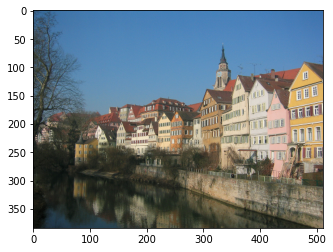

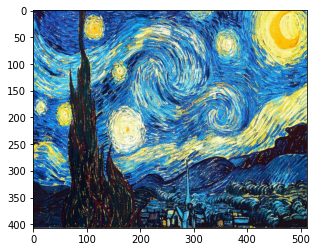

True

In [4]:
##############
# 1. INGESTION
##############
# Load the content image and style image
content_img_path = os.path.join(workspace_dir, 'cimg1_tubingen.png')
content_img_arr = load_img(content_img_path)
helper_show_img(content_img_arr)

style_img_path = os.path.join(workspace_dir, 'simg1_vangogh_starrynight.png')
style_img_arr = load_img(style_img_path)
helper_show_img(style_img_arr)

We will be using the VGG19 model to extract content and style representations from an image. Specificially, we will be using layers in this model to extract content & style. The lower layers represent low-level features like edges & textures (style) and the final few layers represent higher-level features (content).

In [5]:
# For testing
# Load the VGG19 layer
tf.keras.backend.clear_session()
dummy_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for ly in dummy_model.layers:
    print(ly.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Here, we will be choosing the intermediate layers to extract style and content from the image.

In [6]:
# Select the layers to use to extract content & style
vgg_content_layers = ['block5_conv2']
vgg_style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 
                    'block4_conv1', 'block5_conv1']
vgg_content_layers_count, vgg_style_layers_count = len(vgg_content_layers), len(vgg_style_layers)

# Build a model that returns a list of intermediate layer outputs
def vgg_layers(layers):
    # Load the VGG model
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    # get each of the outputs from each of these layers
    outputs = [vgg_model.get_layer(name).output for name in layers]
    # create a model where the input is the image 
    # and the outputs are the layer extractions
    model = tf.keras.Model([vgg_model.input], outputs)
    return model

# Create the style extractor and run the extractor on the style image
style_extractor = vgg_layers(vgg_style_layers)
style_outputs = style_extractor(style_img_arr*255)    

In [7]:
# Look at the statistics of each layer's output
for n, o in zip(vgg_style_layers, style_outputs):
    print(n)
    print("shape: %s, min: %s, max: %s, mean: %s" %
          (o.numpy().shape, o.numpy().min(), o.numpy().max(), o.numpy().mean()))

block1_conv1
shape: (1, 407, 512, 64), min: 0.0, max: 829.49225, mean: 33.912098
block2_conv1
shape: (1, 203, 256, 128), min: 0.0, max: 4896.149, mean: 209.54991
block3_conv1
shape: (1, 101, 128, 256), min: 0.0, max: 9651.159, mean: 224.67773
block4_conv1
shape: (1, 50, 64, 512), min: 0.0, max: 20751.84, mean: 816.5023
block5_conv1
shape: (1, 25, 32, 512), min: 0.0, max: 3270.6987, mean: 65.376015


The gram matrix is simply the outer product of the feature vector with itself, averaged over all locations.

In [8]:
# Calculate style using the Gram matrix across the multiple layers
def gram_matrix(x):
    result = tf.linalg.einsum('bijc,bijd->bcd', x, x)
    x_shape = tf.shape(x)
    num_locations = tf.cast(x_shape[1]*x_shape[2], tf.float32)
    return result/num_locations

In [9]:
# Build the model that extracts style and content from an image
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False
        self.style_layers = style_layers
        self.content_layers = content_layers
        
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        # Extract style: obtain the layer outputs and compute gram matrix
        num_style_layers = len(self.style_layers)
        style_outputs = outputs[:num_style_layers]
        style_outputs = [gram_matrix(style_output) for 
                         style_output in style_outputs]
        style_dict = {style_name: value 
                                for style_name, value 
                                in zip(self.style_layers, style_outputs)}                           

        # Extract content: simply obtain the layer outputs
        content_outputs = outputs[num_style_layers:]
        content_dict = {content_name: value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}
        
        return {'content' : content_dict, 'style' : style_dict}   

extractor = StyleContentModel(vgg_style_layers, vgg_content_layers)                   

In [10]:
# For testing
# Explicitly extract style and content from some dummy image
dummy_results = extractor(tf.constant(content_img_arr))
print('Styles: ')
for n, o in sorted(dummy_results['style'].items()):
    print(n)
    print("shape: %s, min: %s, max: %s, mean: %s" %
          (o.numpy().shape, o.numpy().min(), o.numpy().max(), o.numpy().mean()))
print()
print('Contents: ')
for n, o in sorted(dummy_results['content'].items()):
    print(n)
    print("shape: %s, min: %s, max: %s, mean: %s" %
          (o.numpy().shape, o.numpy().min(), o.numpy().max(), o.numpy().mean()))

Styles: 
block1_conv1
shape: (1, 64, 64), min: 0.049667582, max: 12400.085, mean: 539.4037
block2_conv1
shape: (1, 128, 128), min: 0.0, max: 103051.77, mean: 13224.033
block3_conv1
shape: (1, 256, 256), min: 0.0, max: 233163.55, mean: 13577.584
block4_conv1
shape: (1, 512, 512), min: 0.0, max: 5386595.0, mean: 200994.72
block5_conv1
shape: (1, 512, 512), min: 0.0, max: 247206.56, mean: 1562.5618

Contents: 
block5_conv2
shape: (1, 24, 32, 512), min: 0.0, max: 1290.8989, mean: 14.6345415


In [11]:
# Now, we extract the content and style from the respective images
style_targets = extractor(style_img_arr)['style']
content_targets = extractor(content_img_arr)['content']

In [12]:
# Generate the new image, gimg
generated_image = tf.Variable(content_img_arr)

In [49]:
# Pixel values should be between 0 and 1
def clip_0_1(img):
    return tf.clip_by_value(img, clip_value_min=0.0, clip_value_max=1.0)

# Optimisers for gradient descent
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.75, epsilon=1e-2)

# Use a weighted combination of style and content
style_weight = 1e-2
content_weight = 0.5

In [24]:
# Calculate loss cimg<-->gimg, and simg<-->gimg
def style_content_loss(outputs):
    style_outputs, content_outputs = outputs['style'], outputs['content']
    style_loss = tf.add_n([tf.reduce_mean(style_outputs[name] - style_targets[name])**2
                                          for name in style_outputs.keys()])
    style_loss *= style_weight / vgg_style_layers_count
    content_loss = tf.add_n([tf.reduce_mean(content_outputs[name] - content_targets[name])**2
                                             for name in content_outputs.keys()])
    content_loss *= content_weight / vgg_content_layers_count
    loss = style_loss + content_loss
    return loss

In [25]:
# Define gradient descent
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

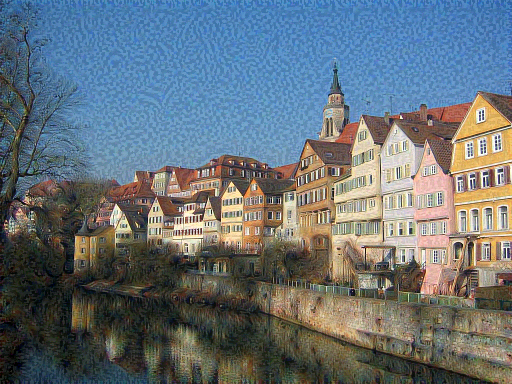

In [26]:
# Run gradient descent on the generated image
generated_image = tf.Variable(content_img_arr)
train_step(generated_image)
train_step(generated_image)
train_step(generated_image)
tf.keras.preprocessing.image.array_to_img(generated_image[0])

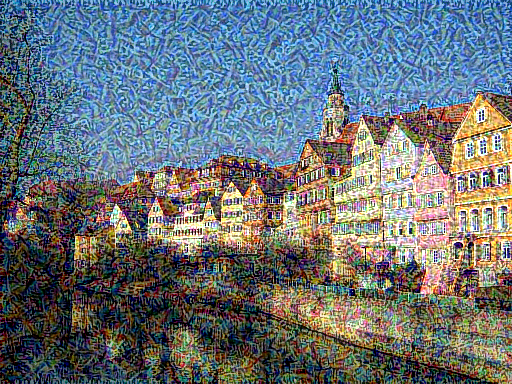

Train step: 50
total time: 9.1


In [28]:
# Finally, generate image
start = time.time()
epochs = 5
steps_per_epoch = 10

step = 0
generated_image = tf.Variable(content_img_arr)
for n in range(epochs):
    for m in range(steps_per_epoch):
        step +=1
        train_step(generated_image)
    display.clear_output(wait=True)
    display.display(tf.keras.preprocessing.image.array_to_img(generated_image[0]))
    print("Train step: {}".format(step))
end = time.time()
print("total time: {:.1f}".format(end-start))

Observe that this has a lot of high frequence outputs. To decrease this, use an explicit regularisation term on the high frequency components of the image. This is called <b>total variation loss</b>. So we add total variation loss to the loss term.

In [29]:
def high_pass_x_y(img):
    x_var = img[:,:,1:,:] - img[:,:,:-1,:]
    y_var = img[:,1:,:,:] - img[:,:-1,:,:]
    return x_var, y_var

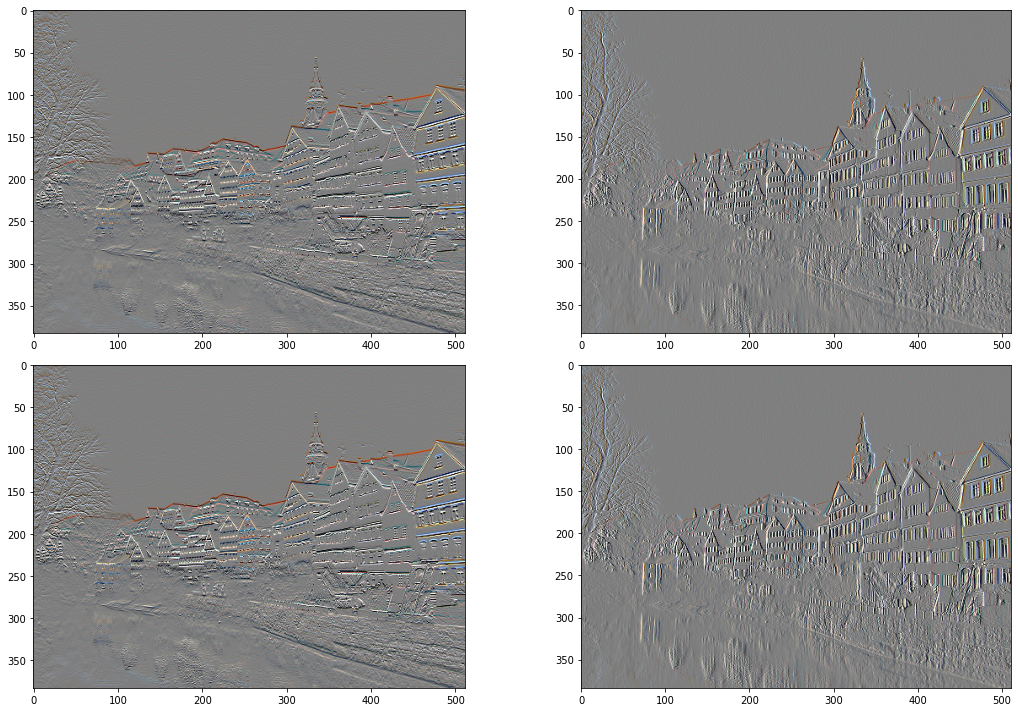

In [30]:
x_deltas, y_deltas = high_pass_x_y(content_img_arr)

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.imshow(clip_0_1(2*y_deltas[0]+0.5))

plt.subplot(2,2,2)
plt.imshow(clip_0_1(2*x_deltas[0]+0.5))

x_delta, y_deltas = high_pass_x_y(content_img_arr)

plt.subplot(2,2,3)
plt.imshow(clip_0_1(2*y_deltas[0]+0.5))

plt.subplot(2,2,4)
plt.imshow(clip_0_1(2*x_deltas[0]+0.5))
plt.tight_layout()

In [31]:
def total_variation_loss(img):
    x_deltas, y_deltas = high_pass_x_y(img)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [32]:
total_variation_loss(generated_image).numpy()

164498.9

In [33]:
tf.image.total_variation(generated_image).numpy()

array([164498.9], dtype=float32)

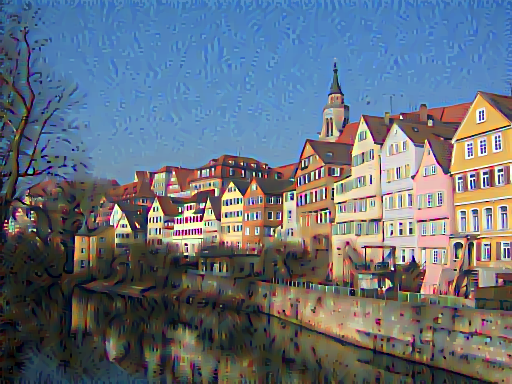

Train step: 1000
total time: 175.3


In [51]:
total_variation_weight = 50
# Running gradient descent to update the image
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

start = time.time()
epochs = 10
steps_per_epoch = 100

step = 0
generated_image = tf.Variable(content_img_arr)
for n in range(epochs):
    for m in range(steps_per_epoch):
        step +=1
        train_step(generated_image)
    display.clear_output(wait=True)
    display.display(tf.keras.preprocessing.image.array_to_img(generated_image[0]))
    print("Train step: {}".format(step))
end = time.time()
print("total time: {:.1f}".format(end-start))    

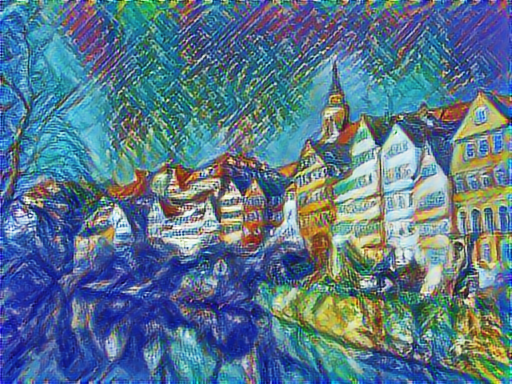

In [52]:
# Using Tensorflow Hub modules to quickly generate the image
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')

hub_generated_img = hub_module(content_img_arr, style_img_arr)[0]
tf.keras.preprocessing.image.array_to_img(hub_generated_img[0])